In [2]:
# Some standard import statements that are nice for Jupyter

# this is necessary for the functions.py file to be imported
# replace the path with the appropriate path to your workspace
import sys
sys.path.append('/ucn/orithyia_data/psi_transmission/scripts')
sys.path.append('/Users/jonahbd/psi_transmission/scripts')


import os
import logging
import ipynb
import decimal
import time
import uncertainties
import datetime as dt
import matplotlib.dates as mdates
from uncertainties import *
import numpy as np
from scipy.optimize import curve_fit
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# prevents the need to reload the kernel everytime functions.py file is updated
%load_ext autoreload
%autoreload 2

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

# importing functions for analysis
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# loading the data sets

# main detector
data_dict, norm_dict = load_all_main()

In [3]:
# monitor detector
monitor_data = load_monitor()

In [4]:
# 2 second proton beam current
p_beam_2s = load_p_beam_2s()

In [5]:
# 10 second proton beam current
p_beam_10s = load_p_beam_10s()

# Monitor Detector Count Data

In this notebook I take a look at the data from the monitor detector. Bernhard Lauss described the monitor detector positioning as follows:

>there you see, that there are 2 beamports in area West called West-1 and West-2 <br/>
which drain UCN from the bottom (W1) and top (W2) of the UCN source storage vessel.

>on West-2 (which is in rate about a factor 10 less than West-1) <br/>
we mounted a small cascade detector - small means 10cm x 10cm active area with 8x 8 sensitive 'pixels'<br/>
this setup stayed always the same and rate changes are due to changes is UCN source intensitites.


>on West-1 the different setups of Edgard were mounted <br/>
with several different flanges etc <br/>
Edgard took various photos of the different setups - hope you have access to those, too<br/>
I don't have them.<br/>
the detector on West-1 is in principal identical to West-2 but it is 4 times as large<br/>
i.e. 20cm x 20cm and has 256 active areas (pixels)


>the files you have are "tof"  files<br/>
this means that the proton beam pulse from the PSI source<br/>
triggered the start of the file <br/>
in reality a pilot pulse (7ms long) coming 10s before the real pulse (8s long)<br/>
starts the file and you see the UCN rate increase of the real pulse<br/>
the file lasts for 300s and then the next pulse<br/>
starts a new file.<br/>
the bin size in your files should be 0.1 s

>you can check that in the file you find<br/>
Dwell Time : 1000000     

>is in terms of 100nanoseconds<br/>
therefore   1'000'000  times 100 ns  = 0.1 s

![](../img/psi_source.png)
![](jonahberean/psi_transmission/img/psi_source.png)

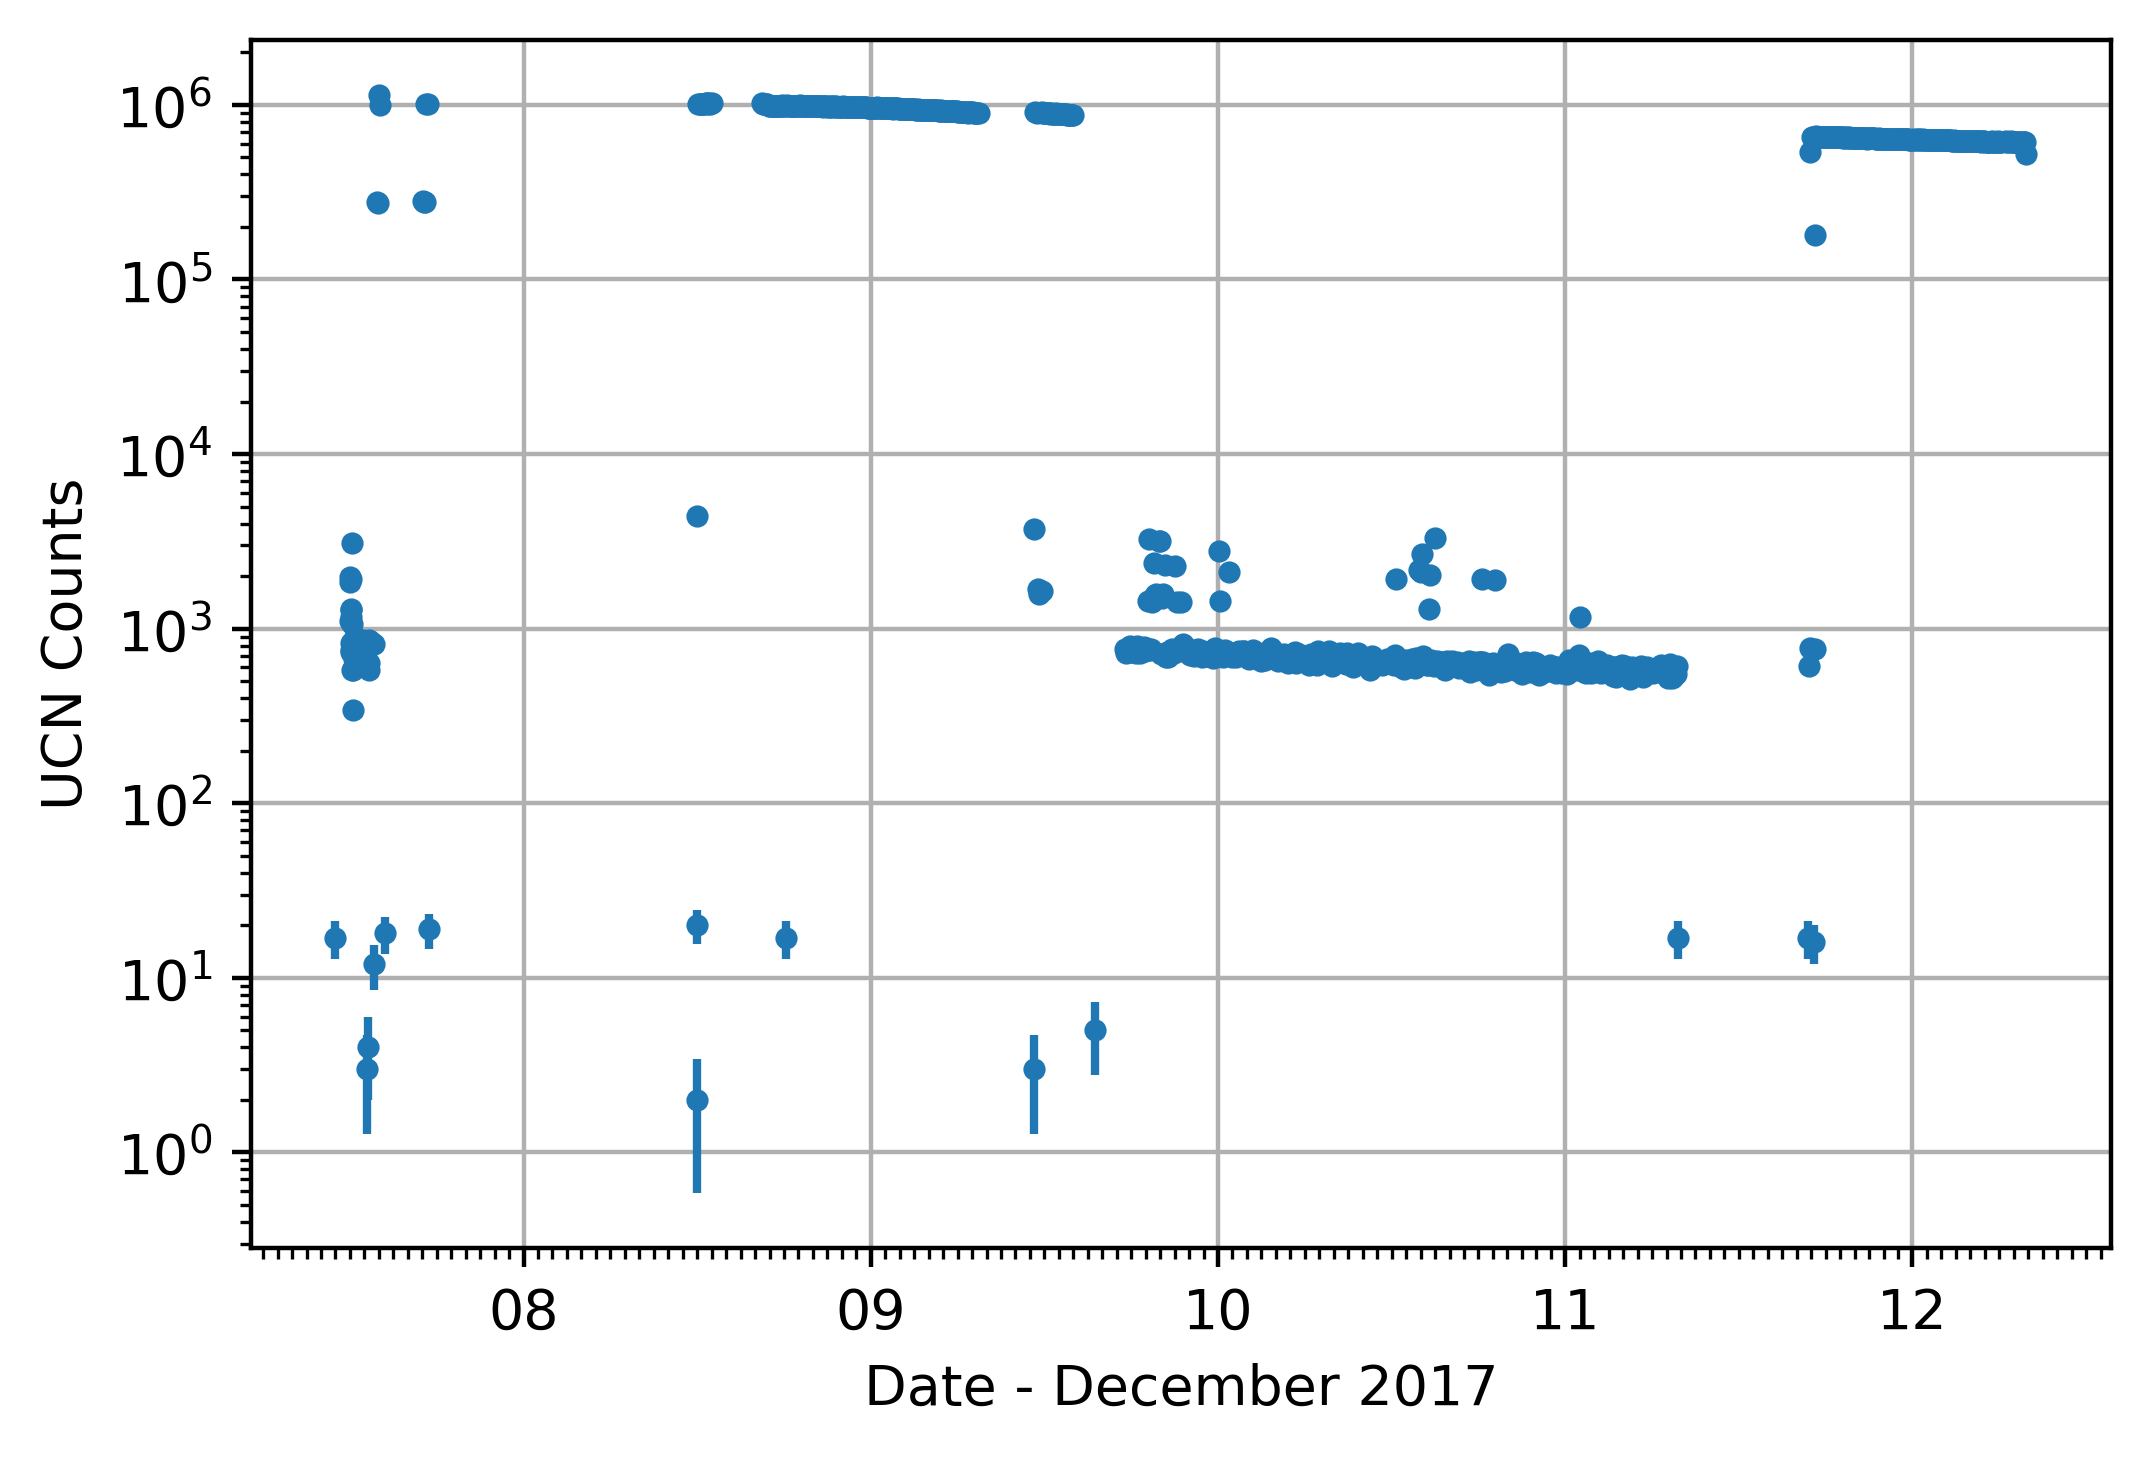

In [82]:
fig, ax = plt.subplots()

x = [dt.datetime.fromtimestamp(d) for d in monitor_data[:,0]]
y = monitor_data[:,1]
yerr = monitor_data[:,2]
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.errorbar(x,y,yerr = yerr, fmt = '.')
ax.set_yscale('log')

ax.set_ylabel('UCN Counts')
ax.set_xlabel('Date - December 2017')
ax.set_yscale('log')
ax.grid(True)
fig.savefig('../img/all_monitor.png', dpi = 600)

The large change (~three orders of magnitude) in counts that is seen at ~1.25e5 seconds might be attributable to a failure to fully open a valve on West-1. This would explain why the counts still retain the linear decay of the UCN source output, but are much lower. Below I've plotted some runs on either side of the change, to get an idea of what the time-of-flight data looked like. Note that this change also occurred directly after a cyclotron outtage, where some configuration tweaking may have been performed by the experimenters. 

From the elog:

>tof.124 = 50908<br/>
tof.125 = 51080<br/>
[Sat, Dec 09, 2017, 14:05:10 ]  cyclotron out... Cyclotron status webpage says 1 hour maintenance.<br/>
[Sat, Dec 09, 2017, 17:36:52 ]  restarted. run 126 is not relevant cause not stable.<br/>
tof.127 =51154 consistent with before.<br/>
[Sat, Dec 09, 2017, 17:40:22 ]  storage 100 s<br/>
tof.128 = 4766

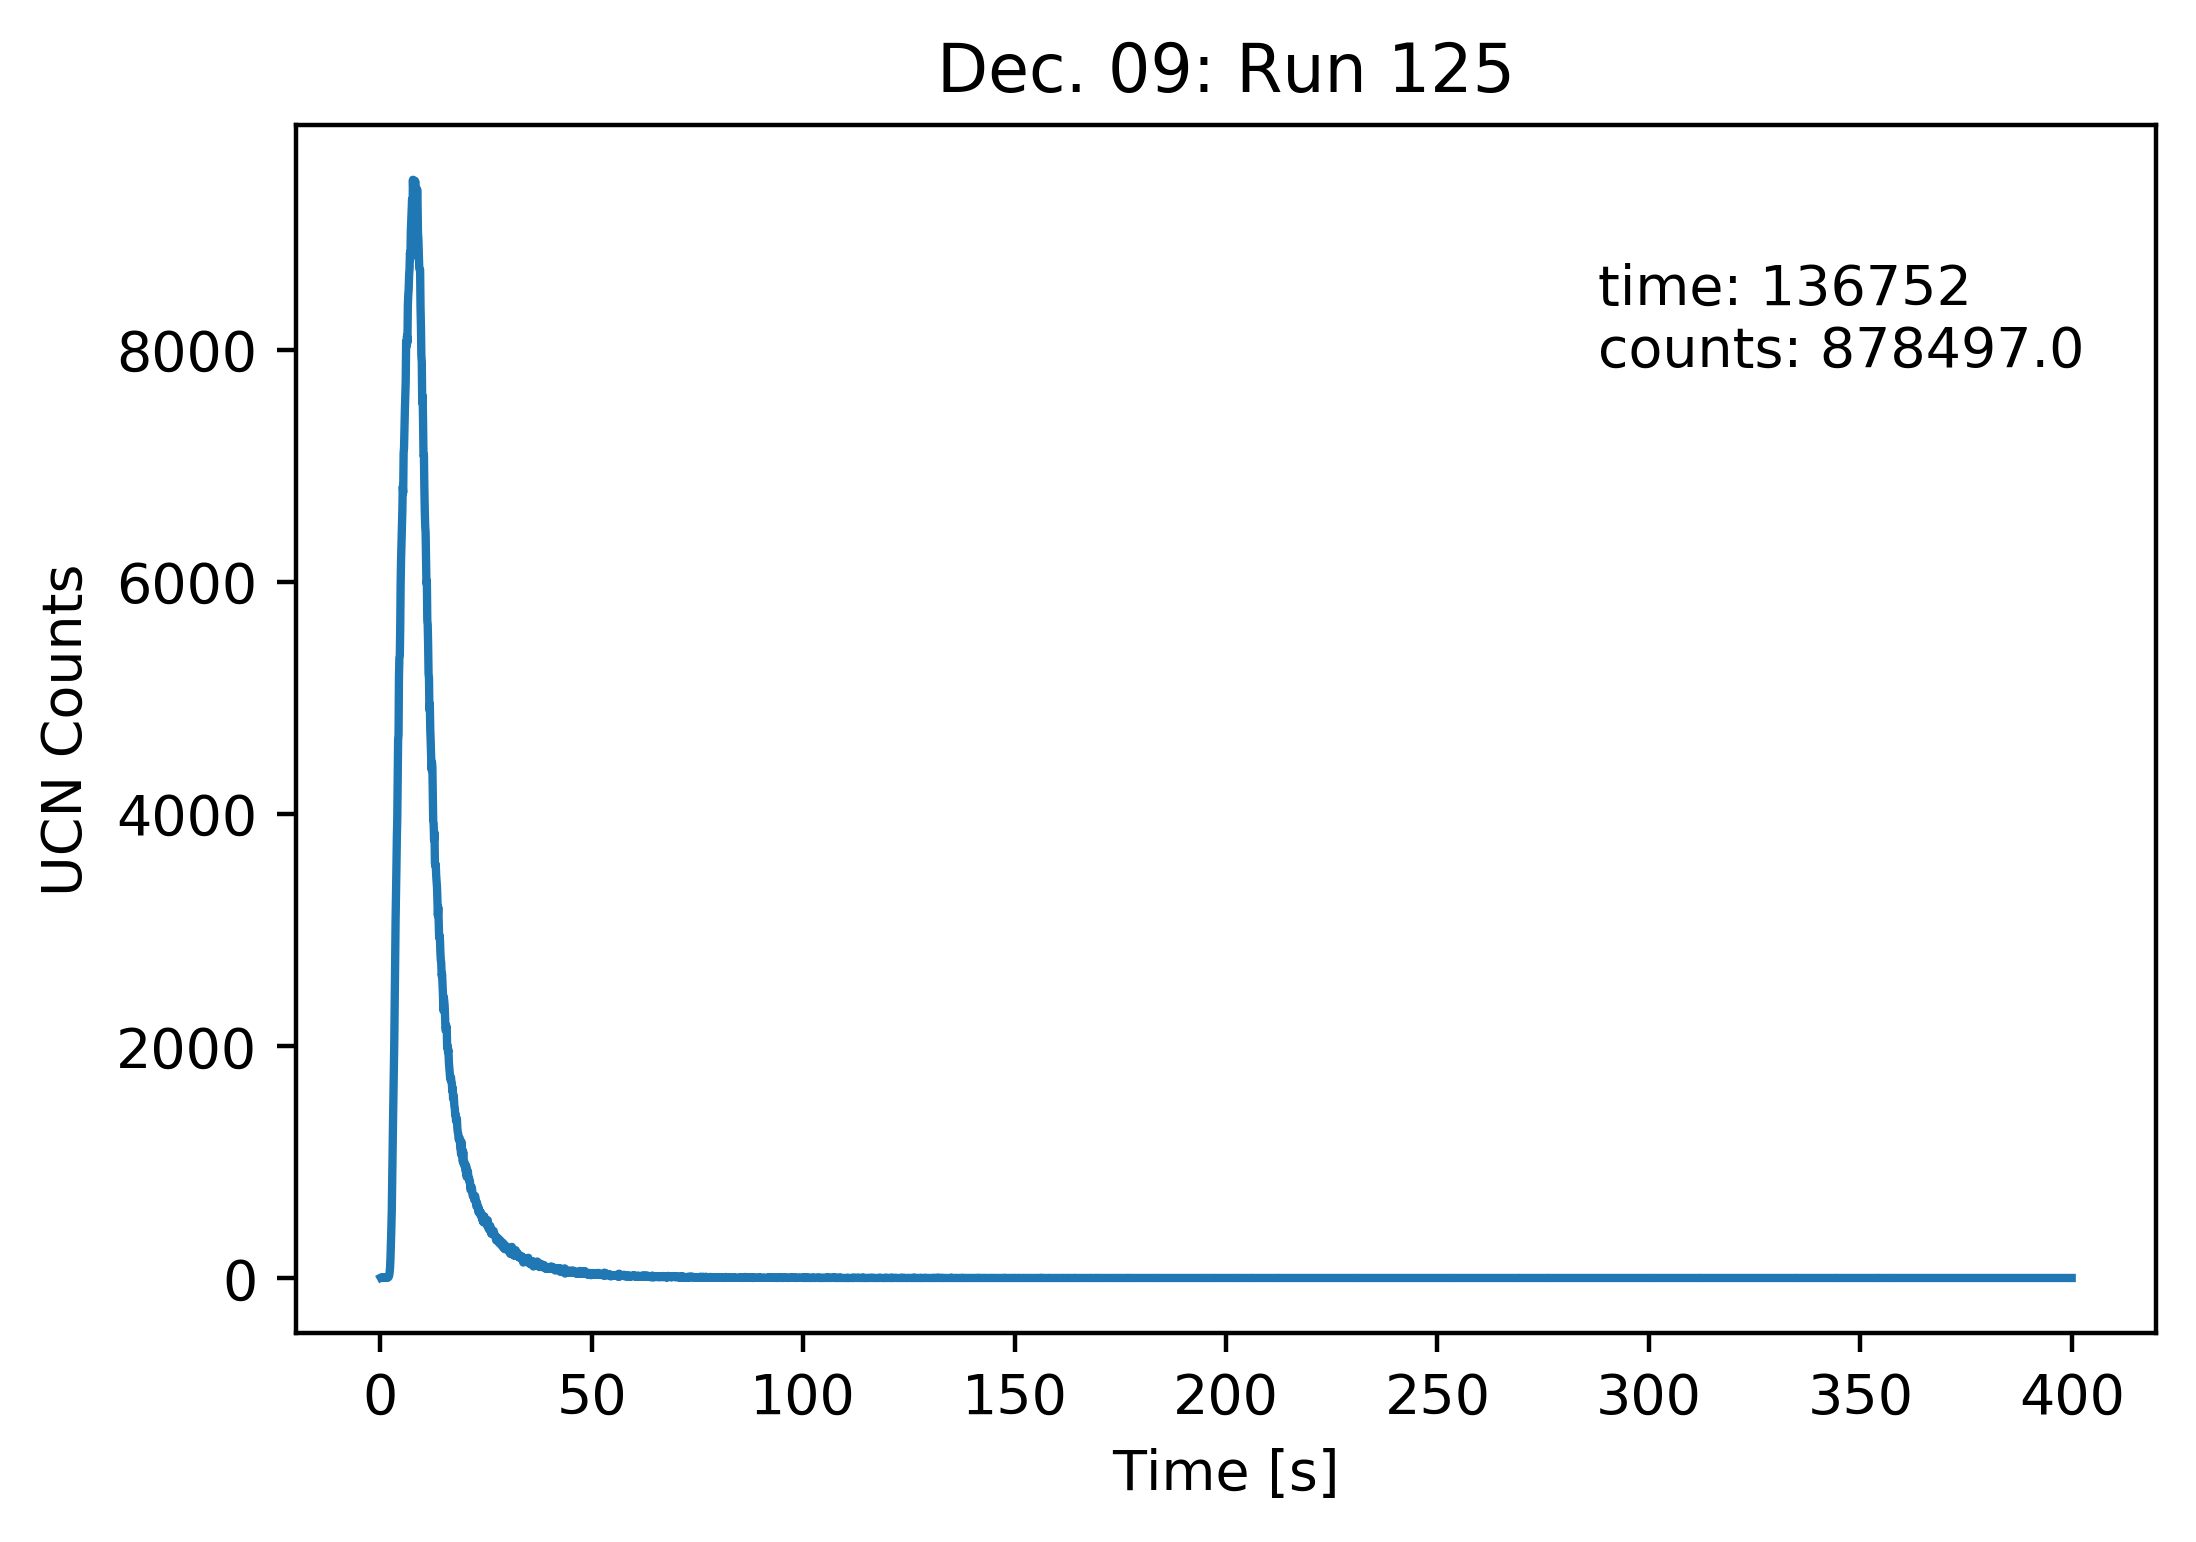

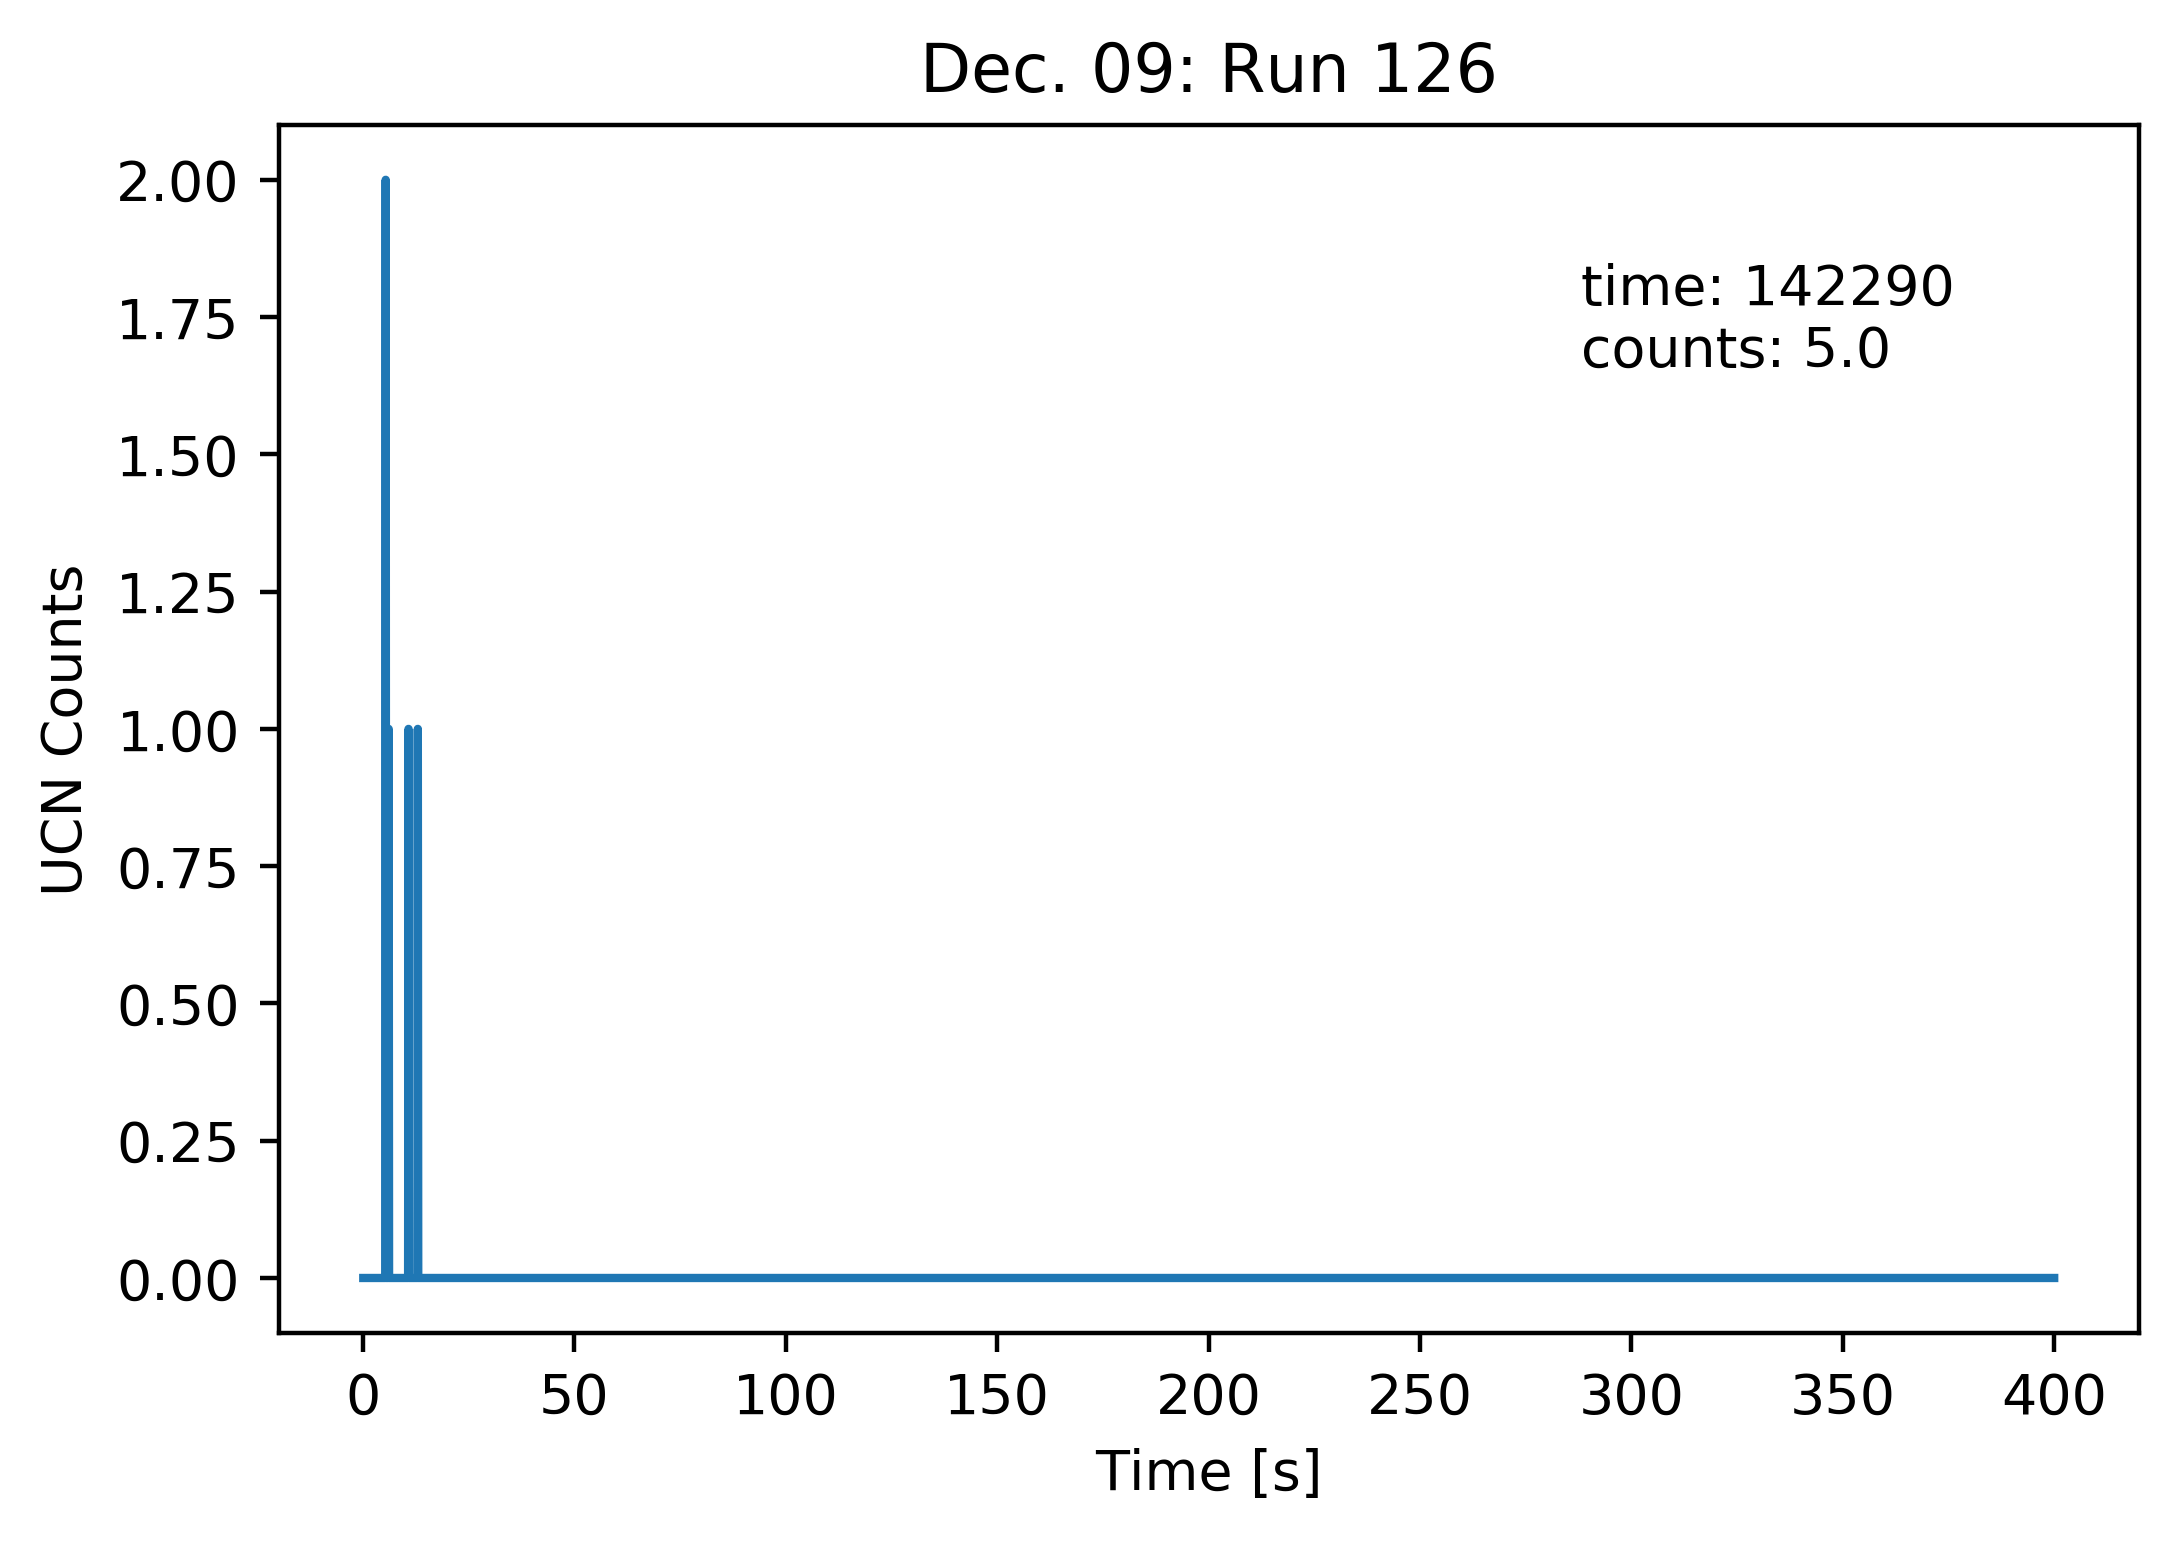

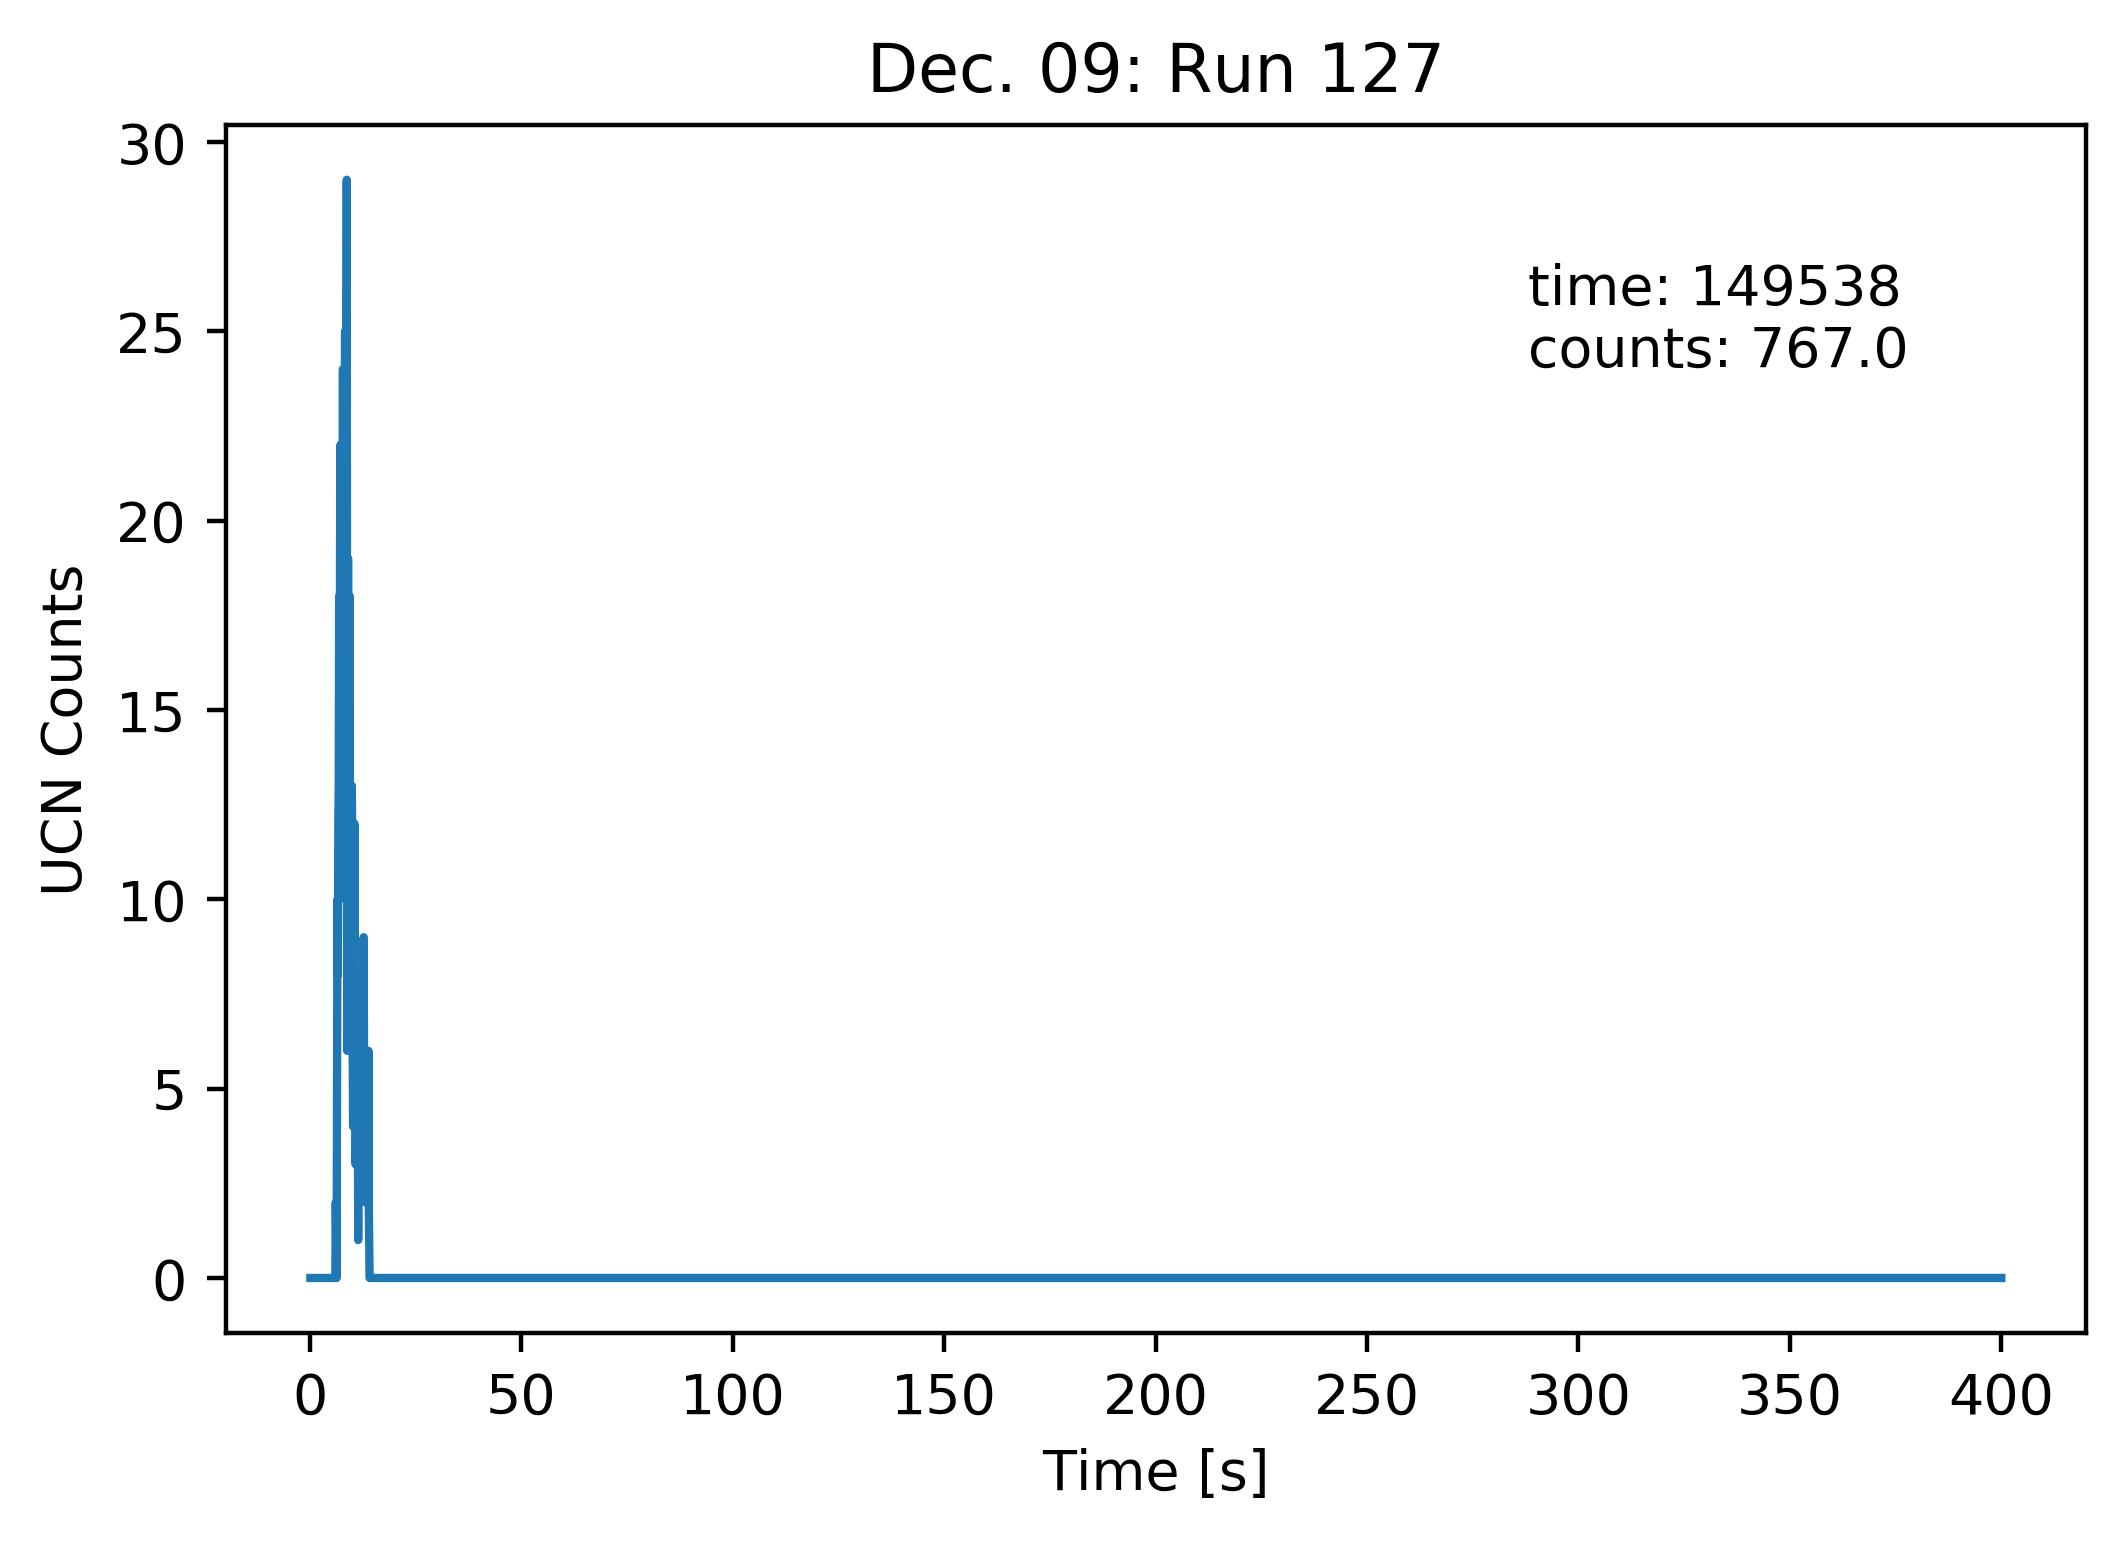

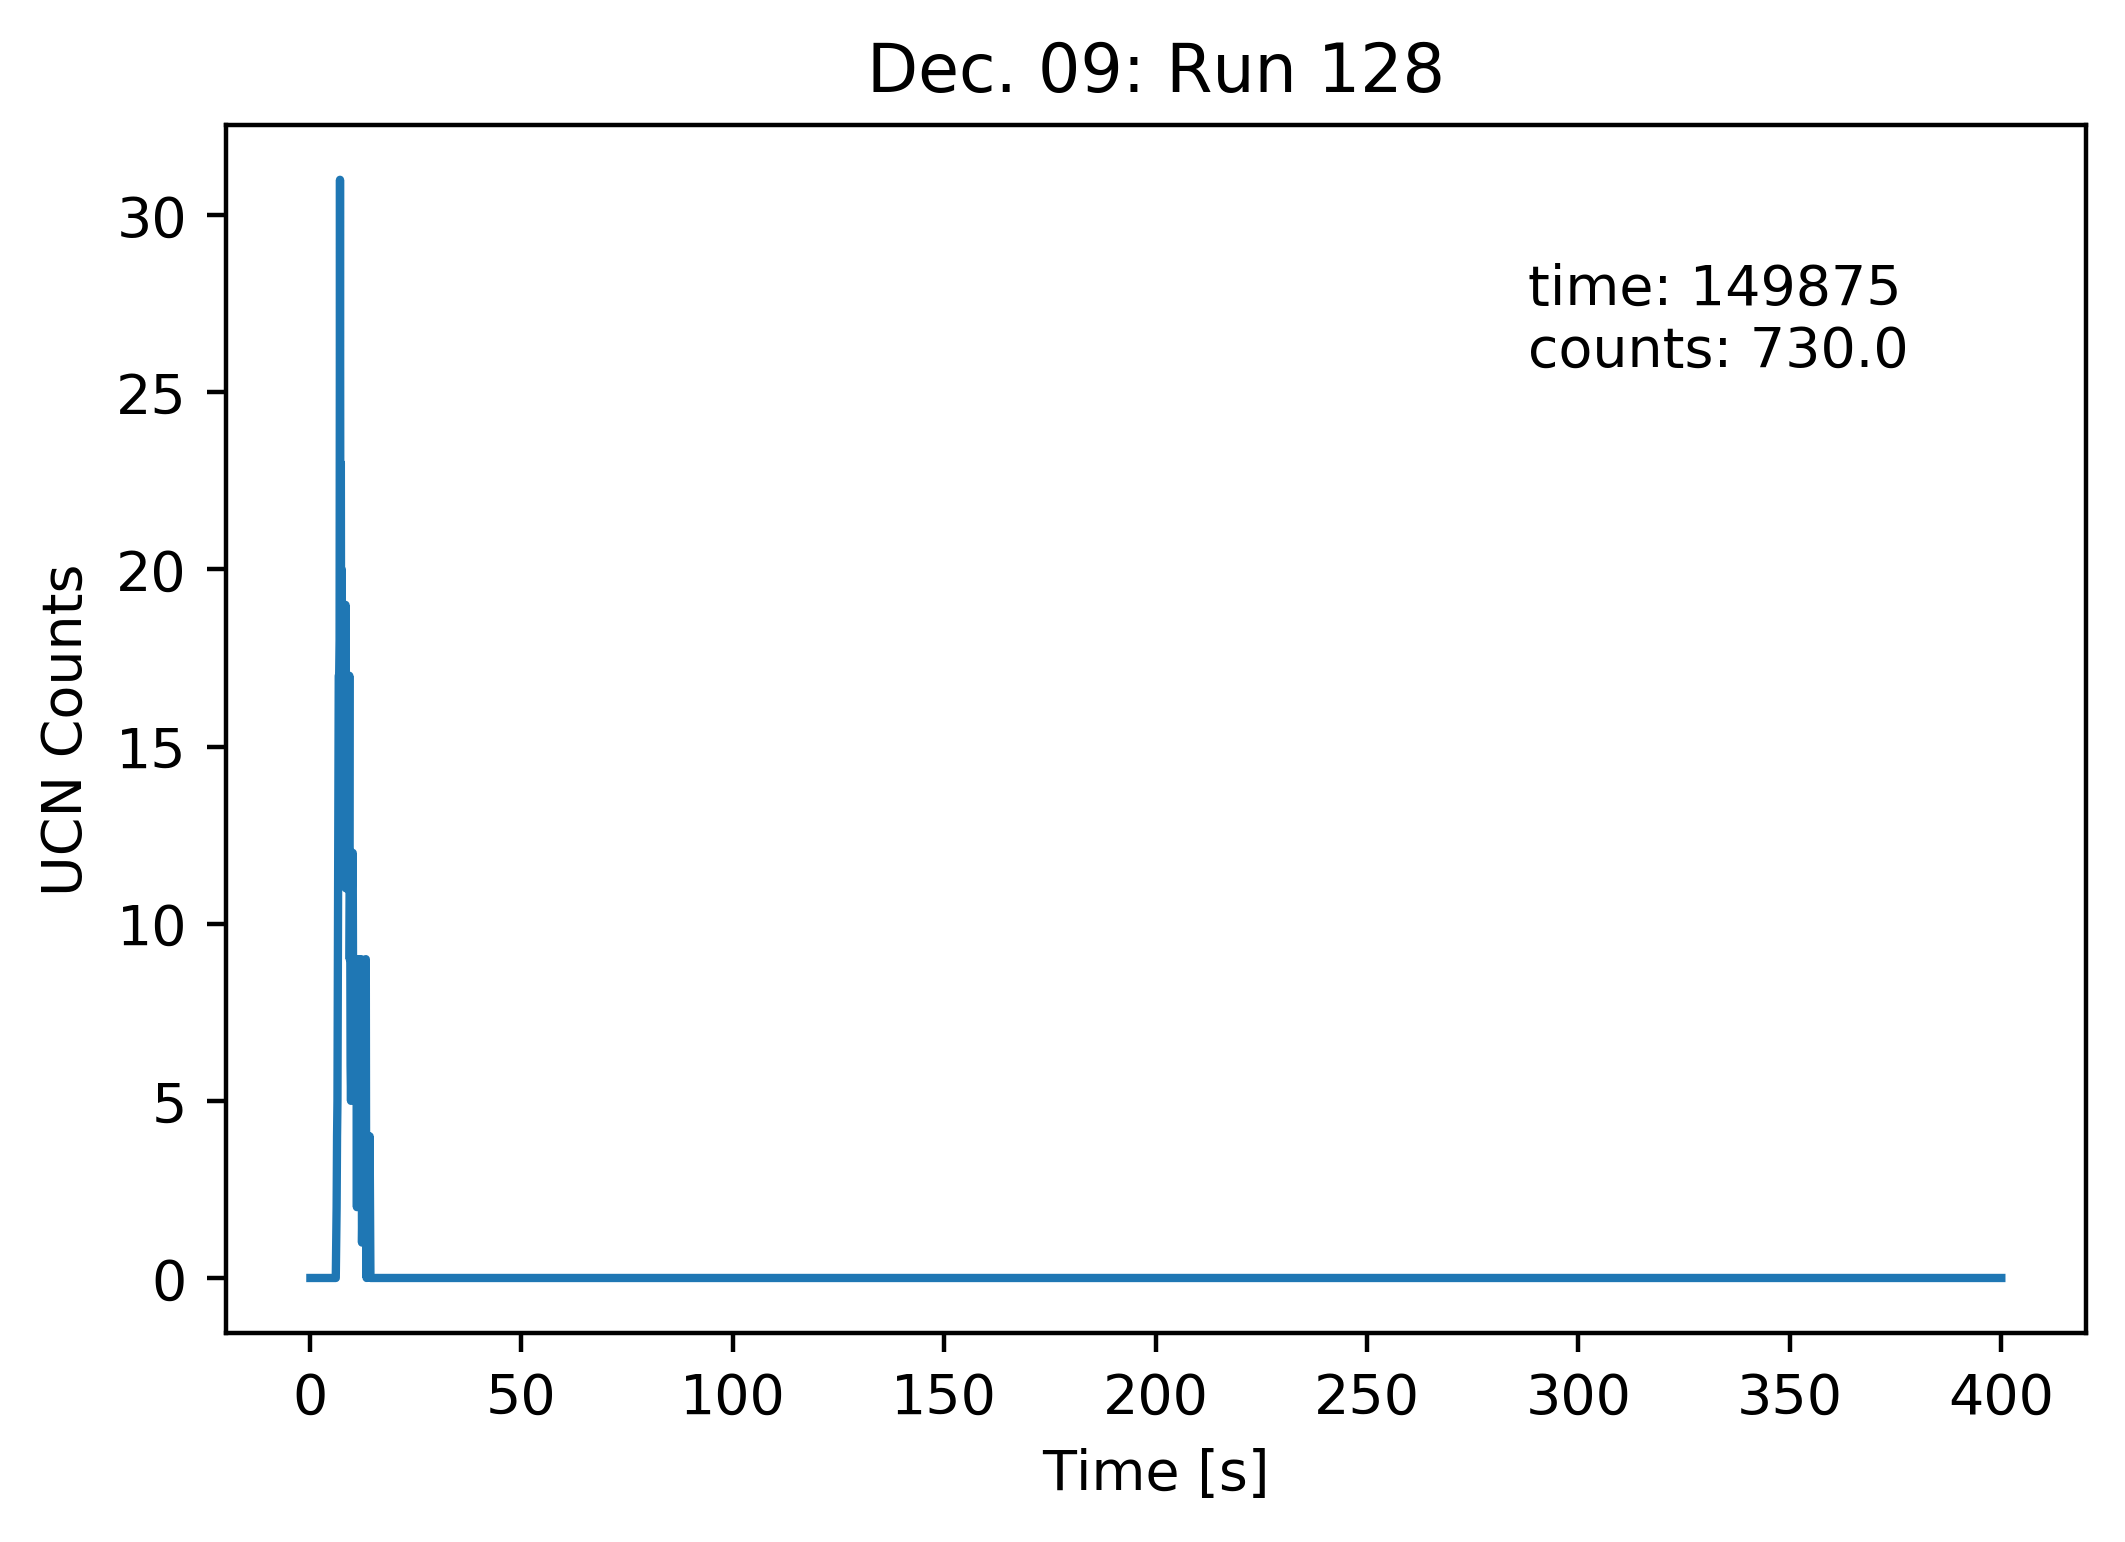

In [49]:
for i in range(124,129):
    data = np.loadtxt("../data_ucn/monitor_detector/T091217_" + str(i).zfill(4) + ".tof", usecols = (0,1));
    fig, ax = plt.subplots()
    
    # grab from the text file associated with the run
    f = open('../data_ucn/monitor_detector/T091217_' + str(i).zfill(4) + '.txt')  

    lines = f.readlines()
    f.close()

    # grab the epoch time for run start
    date_time =  '09.12.2017 '\
        + lines[26][15:23]

    pattern = '%d.%m.%Y %H:%M:%S'
    run_time = int(time.mktime(
        time.strptime(date_time, pattern)))
    
    ax.plot(data[:,0] * 0.1, data[:,1]);
    ax.text(0.7,0.8,'time: {}\ncounts: {}'.format(
        run_time - get_start_time(), np.sum(data[:,1])), transform=ax.transAxes)
    ax.set_xlabel('Time [s]');
    ax.set_ylabel('UCN Counts');
    ax.set_title('Dec. 09: Run ' + str(i))

This transition point is quite clear from viewing these runs directly. 

# Fitting Regions of the Monitor Detector - Looking at Relative Loss

The goal here is straightforward, attempt to reproduce the plot from the paper covering the $s_{D_2}$ frost build-up mechanism. 

![](../img/frost_paper_fig.png)
![](jonahberean/psi_transmission/img/frost_paper_fig.png)

## Three regions of Monitor Detector Data

I'm going to assume that any outlying data points from the three regions of interest are due to proton beam fluctuations. Since we're only interested in confirming this effect from gravity, we can just try to get the basic trend from this data.


### Region 1 ###
Degrees of Freedom = 177
[[Model]]
    Model(linear_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 179
    # variables        = 2
    chi-square         = 7815.78539
    reduced chi-square = 44.1569796
    Akaike info crit   = 679.996172
    Bayesian info crit = 686.370944
[[Variables]]
    N_0:  2666.19952 +/- 45.9658998 (1.72%) (init = 6000)
    y:    1.7618e-06 +/- 3.0385e-08 (1.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(N_0, y) =  1.000


### Region 2 ###
Degrees of Freedom = 420
[[Model]]
    Model(linear_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 422
    # variables        = 2
    chi-square         = 558.229669
    reduced chi-square = 1.32911826
    Akaike info crit   = 122.060897
    Bayesian info crit = 130.150907
[[Variables]]
    N_0:  2744.96077 +/- 72.4058920 (2.64%) (init = 6000)
    y:    1

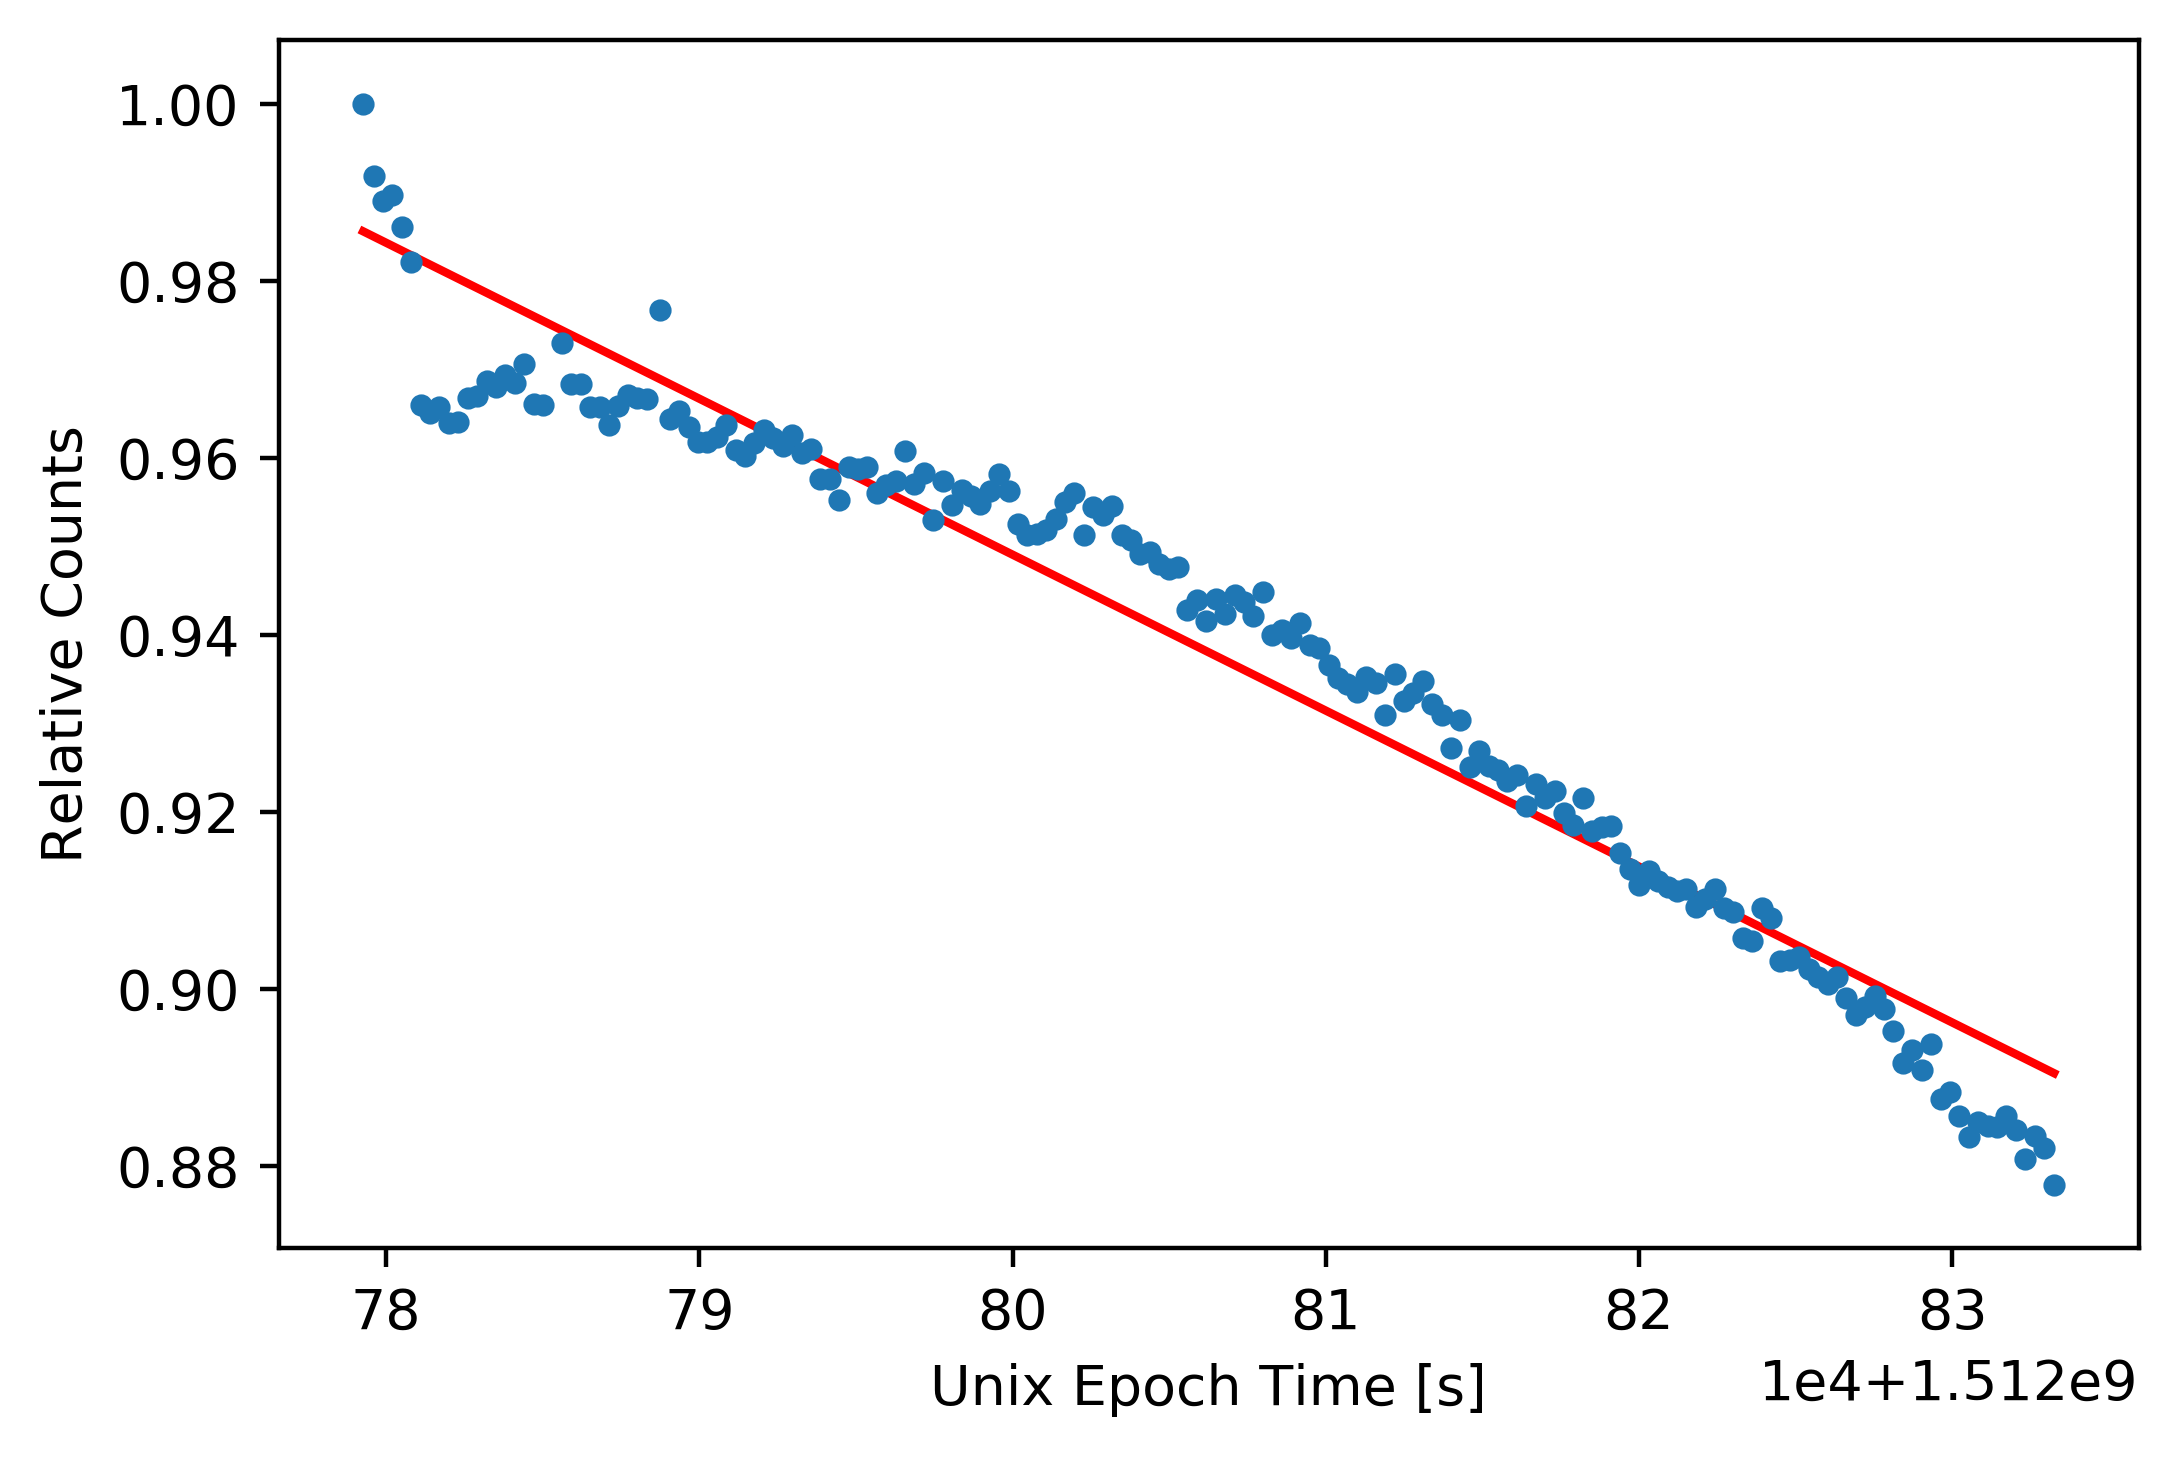

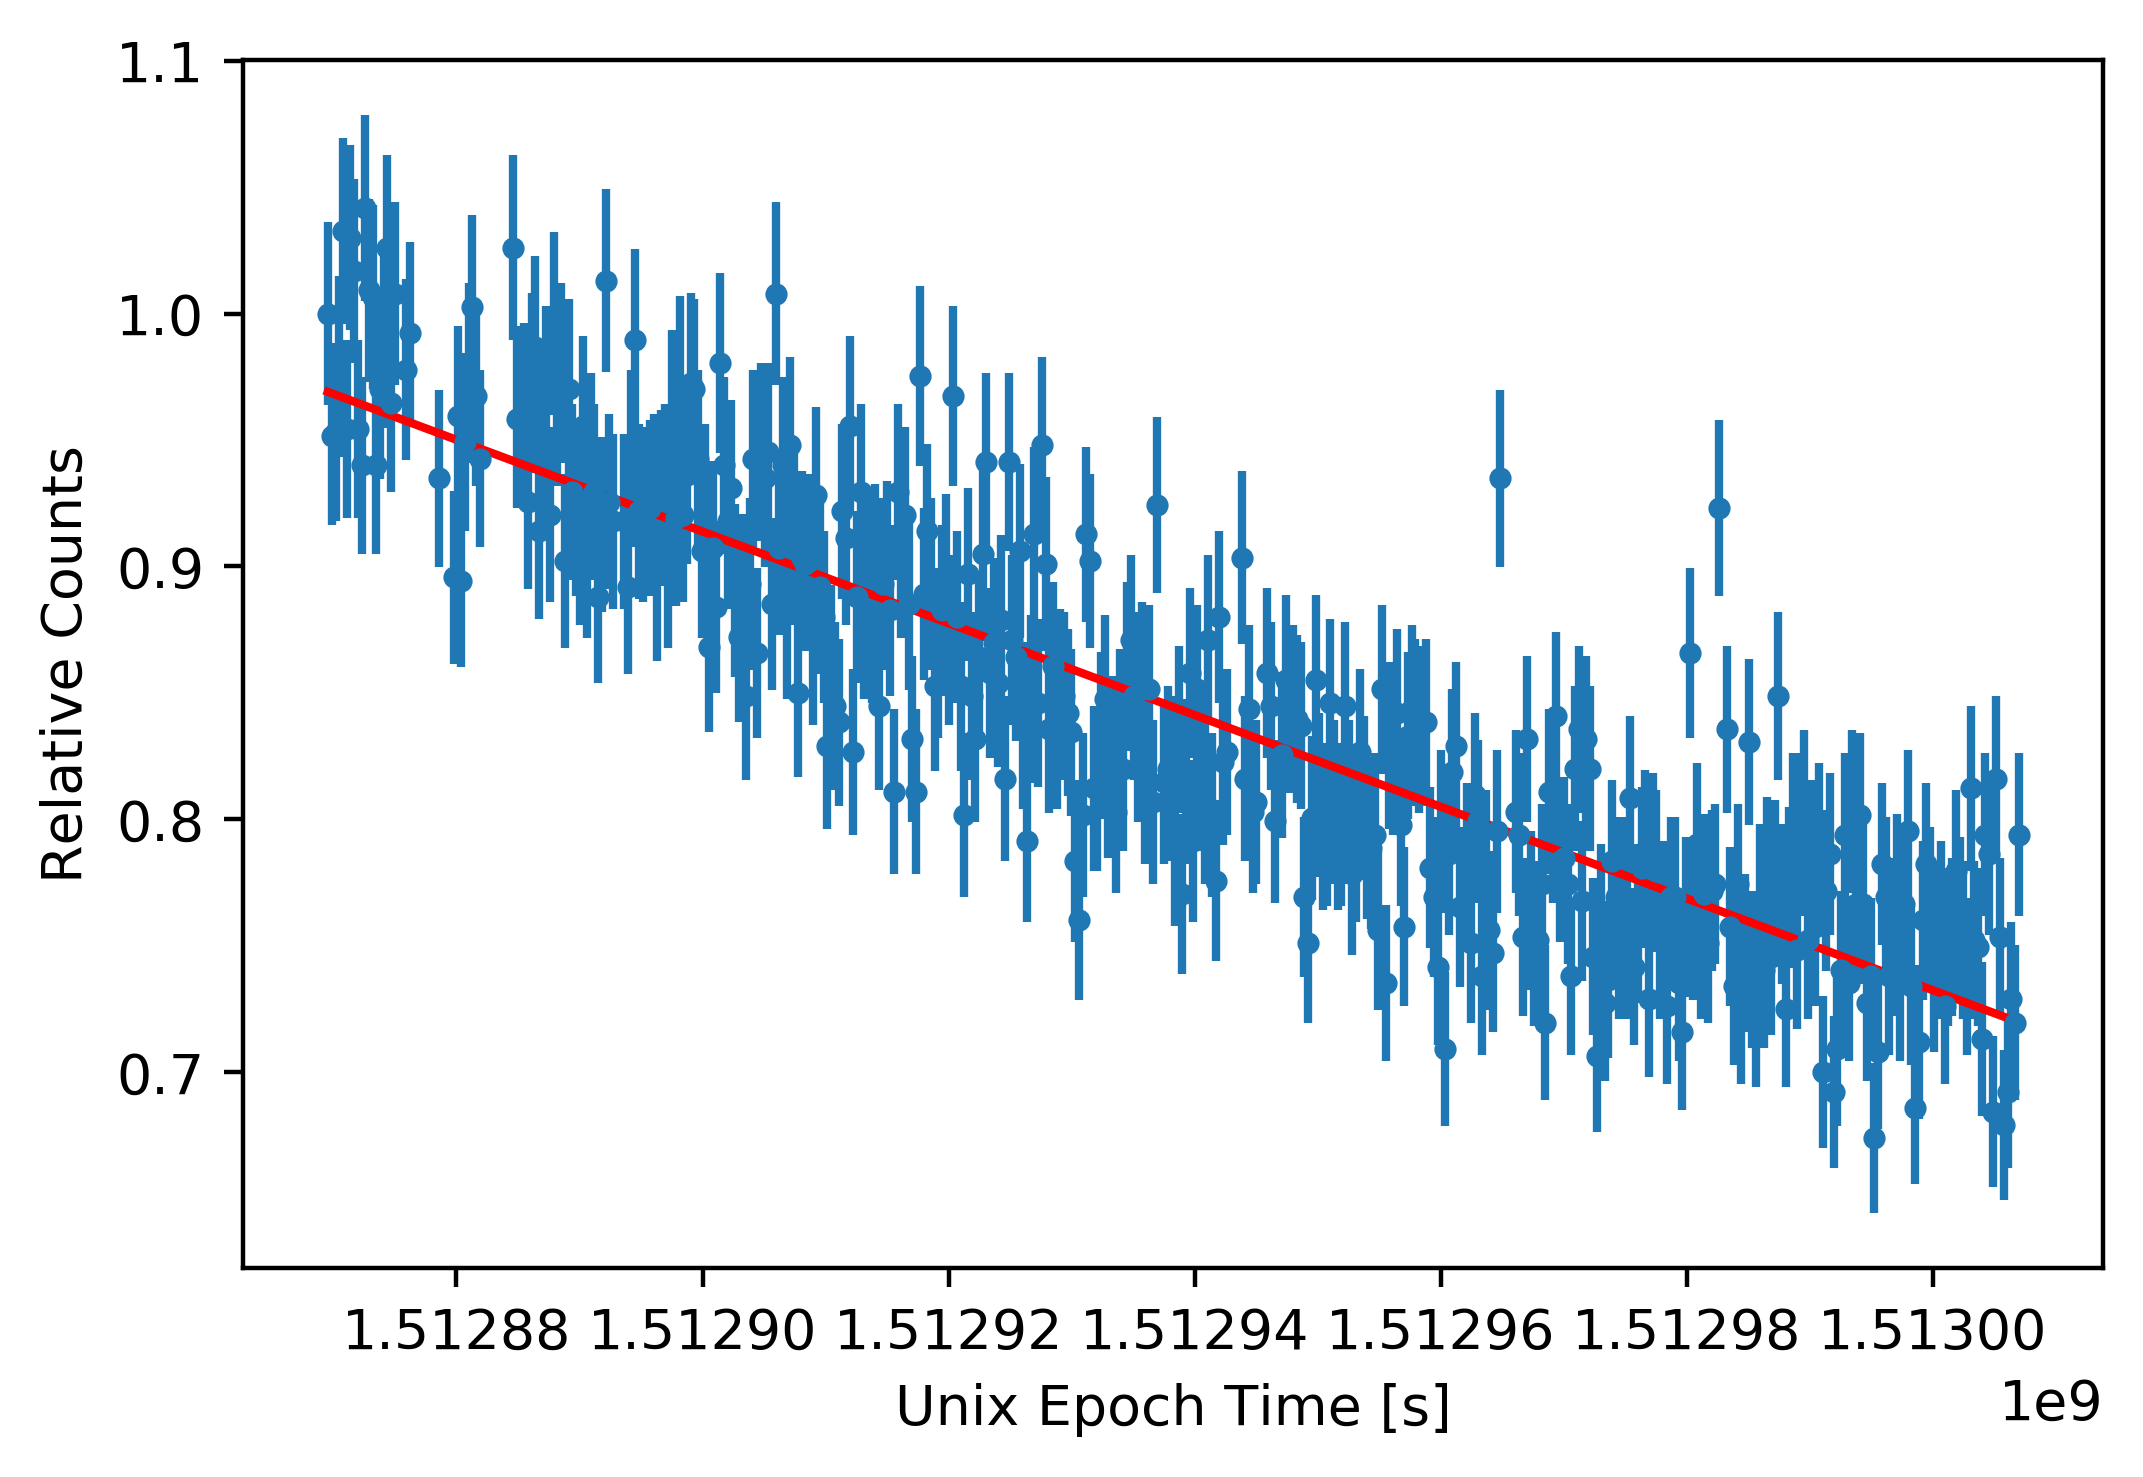

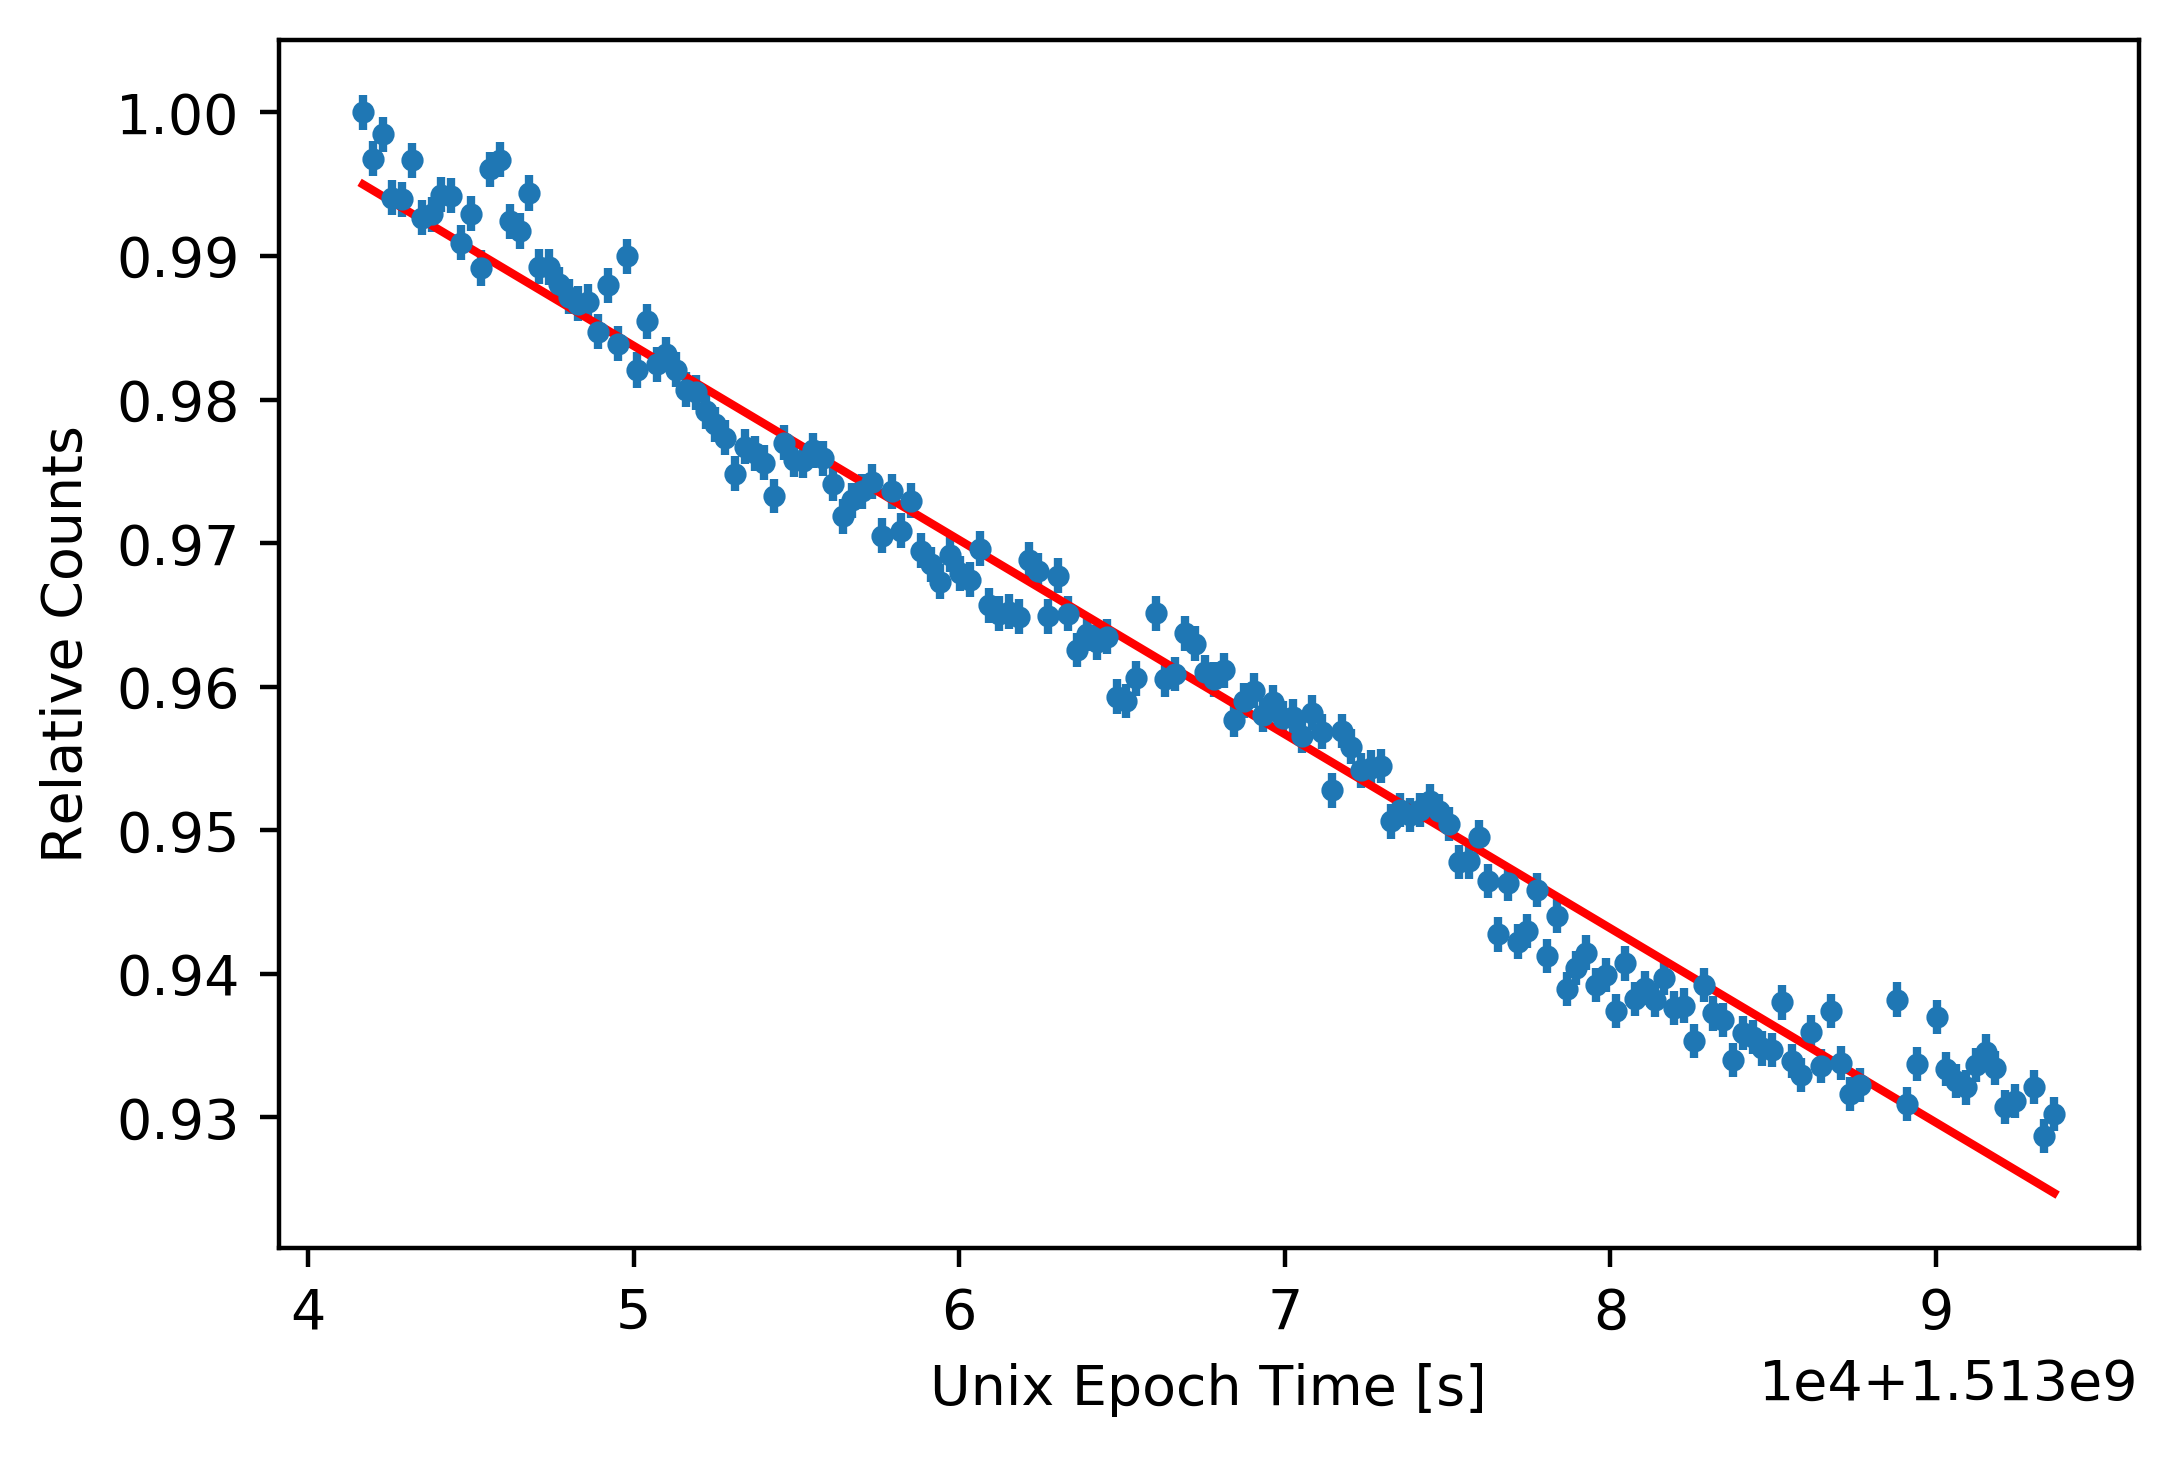

In [41]:
arr = monitor_data
start1 = arr[:,1].argmax()
start2 = (np.where(arr[:,1] > 8e5, arr[:,1], 12e5).argmin())
start3 = np.where(arr[:,1] < 8e5, arr[:,1], 0).argmax()

###############################################################################
### REGION 1 ###
###############################################################################


t1 = arr[start1:start2, 0]
c1 = arr[start1:start2, 1]

# cutting time range
c1 = c1[t1 > 1.51277e9]
t1 = t1[t1 > 1.51277e9]
c1 = c1[t1 < 1.51284e9]
t1 = t1[t1 < 1.51284e9]

# count range
t1 = t1[c1 > 8e2]
c1 = c1[c1 > 8e2]

# error in counts is sqrt(N) from Poisson
c1_err = np.sqrt(c1)

# making the count (and error) values relative to the t1[0] measurement
reference_measurement = c1[0]
c1 = c1 / reference_measurement
c1_err = c1_err / reference_measurement

# plotting and fitting
fig1, ax1 = plt.subplots()
ax1.errorbar(t1, c1, yerr = c1_err, fmt='.')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
gmodel = Model(linear_fit)
result = gmodel.fit(c1, t=t1, N_0=6000, y=20, weights = 1/c1_err)
print('\n### Region 1 ###')
print('Degrees of Freedom = {}'.format(result.nfree))
print(result.fit_report())
ax1.plot(t1, result.best_fit, 'r-');

ax1.set_ylabel('Relative Counts')
ax1.set_xlabel('Unix Epoch Time [s]')
fig1.savefig('../img/monitor_fit_1.pdf')

###############################################################################
### REGION 2 ###
###############################################################################


t2 = arr[start2:start3, 0]
c2 = arr[start2:start3, 1]

# cutting time range
c2 = c2[t2 < 1.513025e9]
t2 = t2[t2 < 1.513025e9]

# count range
t2 = t2[c2 < 8e2]
c2 = c2[c2 < 8e2]
t2 = t2[c2 > 1e2]
c2 = c2[c2 > 1e2]

# error in counts is sqrt(N) from Poisson
c2_err = np.sqrt(c2)

# making the count (and error) values relative to the t1[0] measurement
reference_measurement = c2[0]
c2 = c2 / reference_measurement
c2_err = c2_err / reference_measurement

# plotting and fitting
fig2, ax2 = plt.subplots()
ax2.errorbar(t2, c2, yerr = c2_err, fmt='.')
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
gmodel = Model(linear_fit)
result = gmodel.fit(c2, t=t2, N_0=6000, y=20, weights = 1/c2_err)
print('\n### Region 2 ###')
print('Degrees of Freedom = {}'.format(result.nfree))
print(result.fit_report())
ax2.plot(t2, result.best_fit, 'r-');

ax2.set_ylabel('Relative Counts')
ax2.set_xlabel('Unix Epoch Time [s]')
fig2.savefig('../img/monitor_fit_2.pdf')

###############################################################################
### REGION 3 ###
###############################################################################



t3 = arr[start3:-1, 0]
c3 = arr[start3:-1, 1]

# error in counts is sqrt(N) from Poisson
c3_err = np.sqrt(c3)

# making the count (and error) values relative to the t1[0] measurement
reference_measurement = c3[0]
c3 = c3 / reference_measurement
c3_err = c3_err / reference_measurement

# plotting and fitting
fig3, ax3 = plt.subplots()
ax3.errorbar(t3, c3, yerr = c3_err, fmt='.')
ax3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
gmodel = Model(linear_fit)
result = gmodel.fit(c3, t=t3, N_0=6000, y=20, weights = 1/c3_err)
print('\n### Region 3 ###')
print('Degrees of Freedom = {}'.format(result.nfree))
print(result.fit_report())
ax3.plot(t3, result.best_fit, 'r-');

ax3.set_ylabel('Relative Counts')
ax3.set_xlabel('Unix Epoch Time [s]')
fig3.savefig('../img/monitor_fit_3.pdf')

In [121]:
t_2[t_2 > 1.512887e9] = 0

In [12]:
arr

array([[0.00000000e+00, 5.94000000e+02, 2.43721152e+01, 1.10170000e+01],
       [1.00000000e+00, 9.82648000e+05, 9.91286033e+02, 8.07300000e+00],
       [2.00000000e+00, 6.55453000e+05, 8.09600519e+02, 1.11210000e+01],
       ...,
       [9.13000000e+02, 6.15368000e+05, 7.84453950e+02, 1.20690000e+01],
       [9.14000000e+02, 5.57000000e+02, 2.36008474e+01, 1.10180000e+01],
       [9.15000000e+02, 7.46000000e+02, 2.73130006e+01, 9.17800000e+00]])